In [1]:
from glob import glob
from tqdm import tqdm
from time import time
import argparse
import logging
import os
import cv2
import numpy as np
from PIL import Image
import base64
from matplotlib import pyplot as plt
import torch

from model import Unet
from dataset import load_image
from tensorrt_model import TrtModel

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('true', '1'):
        return True
    elif v.lower() in ('false', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
        
def dice_loss(inputs, targets, smooth=1):
    inputs = inputs.reshape(-1)
    targets = targets.reshape(-1)

    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  

    return 1-dice 

def display_image(img, mask, local = False):
    img = img[0]
    mask = mask[0]
    
    img = np.transpose(img, (1,2,0))
    mask = np.transpose(mask, (1,2,0))
    
    img = img * 255
    img = np.minimum(np.maximum(img, 0), 255)
    mask[mask > 0.5] = 255
    mask[mask <= 0.5] = 0
    
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = img.astype(np.int16)
    green = np.zeros_like(mask)
    green[:,:,1] = mask[:,:,1]
    img[green >= 255] = img[green >= 255] * 3
    img[img >= 255] = 255

    other = np.zeros_like(mask)
    other[:,:,[0,2]] = mask[:,:,[0,2]] 
    img[other >= 255] = img[other >= 255] * 0.3
    
    plt.imshow(img)
    # cv2.imshow('img', img)
    # cv2.waitKey(1)

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
def inference(model_path, data_path, display = False):
    logger.info('model loading.. {}'.format(model_path))
    batch_size = 1
     # os.path.join("..","models","main.trt")
    model = TrtModel(model_path)
    shape = model.engine.get_binding_shape(0)
    
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = Unet().to(device)
    # model.load_state_dict(torch.load('/home/workspace/iot_ai_model/check_points/unet/model_state_dict_latest.pt'))
    # model = model.eval()
    
    # data_paths = glob(dataset_path)
    
    
    logger.info('dataset loading..')
   
    with open(data_path, 'r') as f:
        line = f.readlines()

    total = len(line)
    logger.info('number of test dataset : {}'.format(total))
    
    logger.info('start inferencing')
    preds = []
    targets = []
    cnt = 0
    
    base_dir = os.path.dirname(data_path)
    imgs = []
    masks = []
    filepaths = []
    
#     for row in tqdm(line):
#         img_path, mask_path = row.rstrip().split(',')
        
#         img = load_image(os.path.join(base_dir, img_path))
#         mask = load_image(os.path.join(base_dir, mask_path))
#         img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
#         mask = mask.reshape(1, mask.shape[0], mask.shape[1], mask.shape[2])
        
#         imgs.append(img)
#         masks.append(mask)
#         filepaths.append(os.path.basename(img_path))
    
    start_time = time()
    pre_elap = 0.0
    fps = 0.0
    cost = .0
    loss = .0
    for idx, row in enumerate(line):
        filename, _ = row.rstrip().split(',')
        filename = os.path.basename(filename)
        
        img = load_image(os.path.join(base_dir, 'images', filename))
        mask = load_image(os.path.join(base_dir, 'masks', filename))
        img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        mask = mask.reshape(1, mask.shape[0], mask.shape[1], mask.shape[2])
        
        # img = load_image(os.path.join(base_dir,'images',filename))
        # img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        
        # img = torch.tensor(img).to(device).type(torch.float32)
        # mask = torch.tensor(mask).to(device).type(torch.float32)
        
        # print(img)
        
        output = model(img)
        output = output[0].reshape(mask.shape)
        
        loss = dice_loss(output, output)
        
        cost += loss
        
        print('{}/{} - {},  fps: {:.1f}, dice loss: {:.1f}'.format(idx+1, total, filename, fps, (loss)))

        # if(display):
        display_image(img, output)
        
        elap = time() - start_time
        fps = max(0.0, 1.0 / (elap - pre_elap))
        pre_elap = elap
        
        
        
    if(display):
        cv2.destroyAllWindows()

    # preds = torch.tensor(preds)
    # targets = torch.tensor(targets)
    # # acc = (correct/len(dataset))
    # f1_score = f1(preds, targets) 
    
    elap = time() - start_time
    fps = total / elap
    logger.info('dice coefficient: {:.4f}, fps: {:.4f}'.format(cost/total, fps))

2022-10-05 06:06:20,192 - model loading.. /home/workspace/iot_ai_model/check_points/unet/model.engine
2022-10-05 06:06:20,246 - dataset loading..
2022-10-05 06:06:20,248 - number of test dataset : 534
2022-10-05 06:06:20,249 - start inferencing


load /home/workspace/iot_ai_model/check_points/unet/model.engine
1/534 - ds5_pexels-photo-245241.png,  fps: 0.0, dice loss: 0.1
2/534 - ds8_pexels-photo-66152_GX5RTeXShS.png,  fps: 20.0, dice loss: 0.0
3/534 - ds6_light-red-white-home.png,  fps: 27.7, dice loss: 0.0
4/534 - ds6_pexels-photo-756439.png,  fps: 32.5, dice loss: 0.0
5/534 - ds6_pexels-photo-819398.png,  fps: 35.2, dice loss: 0.1
6/534 - ds8_pexels-photo-303473.png,  fps: 51.2, dice loss: 0.1
7/534 - ds10_thailand-costume-girl-woman-157857.png,  fps: 28.3, dice loss: 0.0
8/534 - ds8_pexels-photo-207772_aEgMrxjXyq.png,  fps: 26.8, dice loss: 0.1
9/534 - ds8_studio-portrait-blond-blondie-girl-47736.png,  fps: 27.7, dice loss: 0.0
10/534 - ds1_pexels-photo-373984.png,  fps: 43.3, dice loss: 0.0
11/534 - ds2_pexels-photo-194087.png,  fps: 28.4, dice loss: 0.0
12/534 - ds8_pexels-photo-590479.png,  fps: 28.9, dice loss: 0.0
13/534 - ds8_pexels-photo-413805.png,  fps: 38.1, dice loss: 0.0
14/534 - ds1_bow-tie-fashion-man-person.p

KeyboardInterrupt: 

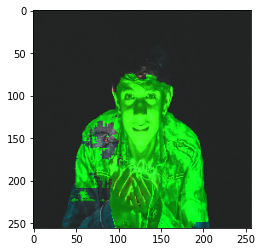

In [38]:
inference('/home/workspace/iot_ai_model/check_points/unet/model.engine', '/home/workspace/iot_ai_model/dataset/supervisely_person/test_data_list.txt')

In [39]:
path = '/home/workspace/iot_ai_model/dataset/supervisely_person/images/ds5_pexels-photo-245241.png'

In [40]:
org = cv2.imread(path)
org = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)

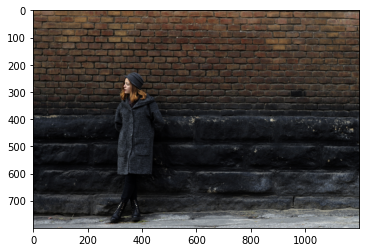

In [41]:
plt.imshow(org)

In [415]:
img = cv2.imread(path)

In [416]:
img = cv2.resize(img, (256,256))

In [417]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

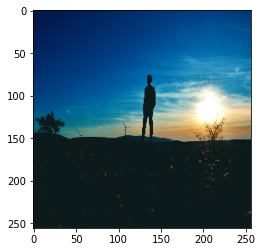

In [418]:
plt.imshow(img)

In [419]:
img = np.array([img], dtype=np.float32) / 255.

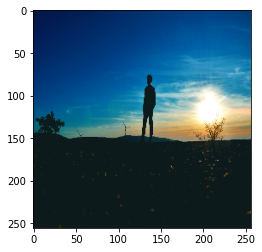

In [420]:
plt.imshow(img[0])

In [421]:
img = np.array(img, dtype=np.float32) * 255.

2022-10-05 05:07:08,802 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-10-05 05:07:08,802 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-10-05 05:07:08,802 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-10-05 05:07:08,802 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-10-05 05:07:08,802 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-10-05 05:07:08,802 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


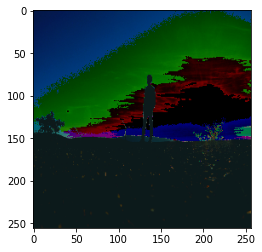

In [422]:
plt.imshow(img[0].astype(np.int8))

In [369]:
img.dtype

dtype('float32')

In [370]:
img = np.transpose(img, (0, 3, 1, 2))

In [371]:
img = np.transpose(img[0], (1, 2, 0)) * 255

In [376]:
a = img.astype(np.int8)

In [42]:
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
img = img.astype(np.float32) / 255.
img = np.transpose(img, (2, 0, 1))
img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

In [43]:
data = img

In [44]:
import onnxruntime as onnxrt

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_t = Unet().to(device)
model_t.load_state_dict(torch.load('/home/workspace/iot_ai_model/check_points/unet/model_state_dict_latest.pt'))
model_t = model_t.eval()

In [464]:
onnx_session = onnxrt.InferenceSession('/home/workspace/iot_ai_model/check_points/unet/model.onnx')

In [465]:
model = TrtModel('/home/workspace/iot_ai_model/check_points/unet/model.engine')
shape = model.engine.get_binding_shape(0)

load /home/workspace/iot_ai_model/check_points/unet/model.engine


In [46]:
data_t = torch.tensor(data).cuda()

In [47]:
data_t.shape, data.shape

(torch.Size([1, 3, 256, 256]), (1, 3, 256, 256))

In [48]:
with torch.no_grad():
    # out = model(data)
    
    out_t = model_t(data_t)

In [472]:
with torch.no_grad():
    out = model(data)
    
    out_t = model_t(data_t)
    
    onnx_inputs= { onnx_session.get_inputs()[0].name: data }
    onnx_output = onnx_session.run(None, onnx_inputs)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR
You can try to repro this exception using the following code snippet. If that doesn't trigger the error, please include your original repro script when reporting this issue.

import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
data = torch.randn([1, 256, 32, 32], dtype=torch.float, device='cuda', requires_grad=True)
net = torch.nn.Conv2d(256, 256, kernel_size=[3, 3], padding=[1, 1], stride=[2, 2], dilation=[1, 1], groups=1)
net = net.cuda().float()
out = net(data)
out.backward(torch.randn_like(out))
torch.cuda.synchronize()

ConvolutionParams 
    data_type = CUDNN_DATA_FLOAT
    padding = [1, 1, 0]
    stride = [2, 2, 0]
    dilation = [1, 1, 0]
    groups = 1
    deterministic = false
    allow_tf32 = true
input: TensorDescriptor 0x10ae78ae0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 256, 32, 32, 
    strideA = 262144, 1024, 32, 1, 
output: TensorDescriptor 0x10a2322e0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 256, 16, 16, 
    strideA = 65536, 256, 16, 1, 
weight: FilterDescriptor 0x10a224cf0
    type = CUDNN_DATA_FLOAT
    tensor_format = CUDNN_TENSOR_NCHW
    nbDims = 4
    dimA = 256, 256, 3, 3, 
Pointer addresses: 
    input: 0x7f4613500000
    output: 0x7f46136c0000
    weight: 0x7f46146c0000
Additional pointer addresses: 
    grad_output: 0x7f46136c0000
    grad_input: 0x7f4613500000
Backward data algorithm: 0


In [50]:
out_t[out_t > 0.5] = 1.
out_t[out_t <= 0.5] = 0.

In [51]:
t = out_t * 256

In [264]:
t[t >= 1]

tensor([256., 256., 256.,  ..., 256., 256., 256.], device='cuda:0')

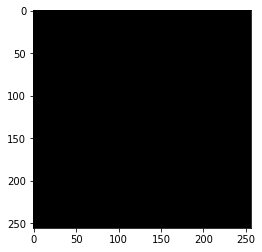

In [265]:
plt.imshow(t[0].transpose(2,0).cpu().type(torch.int8))

In [271]:
from dataset import ImageDataset
dataset = ImageDataset("/home/workspace/iot_ai_model/dataset/supervisely_person", augmentation=False)

images Loading: 2667it [01:12, 36.88it/s] 
masks Loading: 2667it [00:38, 69.00it/s] 


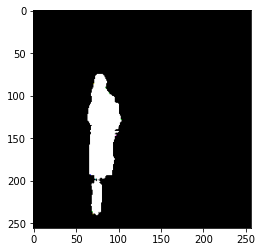

In [52]:
plt.imshow(out_t[0].cpu().numpy().transpose(1,2,0))

In [272]:
dataset[0]

('/home/workspace/iot_ai_model/dataset/supervisely_person/images/ds10_pexels-photo-687782.png',
 tensor([[[0.0196, 0.0235, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0118, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
          [0.0235, 0.0118, 0.0235,  ..., 0.0039, 0.0000, 0.0039],
          ...,
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471]],
 
         [[0.0980, 0.0980, 0.0980,  ..., 0.2196, 0.2157, 0.2196],
          [0.0941, 0.0941, 0.0941,  ..., 0.2196, 0.2196, 0.2196],
          [0.0941, 0.0941, 0.0980,  ..., 0.2235, 0.2275, 0.2235],
          ...,
          [0.1020, 0.1020, 0.1020,  ..., 0.1020, 0.1020, 0.1020],
          [0.1020, 0.1020, 0.1020,  ..., 0.1020, 0.1020, 0.1020],
          [0.1020, 0.1020, 0.1020,  ..., 0.1020, 0.1020, 0.1020]],
 
         [[0.2627, 0.2667, 0.2588,  ..., 0.4431, 0.4392, 0.4392],
          

In [22]:
py = np.array([[1,1,1],[2,2,2]])

In [23]:
py

array([[1, 1, 1],
       [2, 2, 2]])

In [24]:
py.reshape(1, py.shape[0], py.shape[1])

array([[[1, 1, 1],
        [2, 2, 2]]])

In [29]:
np.squeeze(py)

array([[1, 1, 1],
       [2, 2, 2]])

In [ ]:
np.unsq

In [30]:
np.unsqueeze(py)

AttributeError: module 'numpy' has no attribute 'unsqueeze'

In [3]:
py.shape

(2, 3)

In [4]:
py.reshape(3,2)

array([[1, 1],
       [1, 2],
       [2, 2]])

In [6]:
np.transpose(py,(1,0))

array([[1, 2],
       [1, 2],
       [1, 2]])

In [54]:
with open('/home/workspace/iot_ai_model/dataset/supervisely_person/test_data_list.txt', 'r') as f:
    lines = f.readlines()

In [55]:
import os
with open('/home/workspace/iot_ai_model/dataset/supervisely_person/test_data_list.txt', 'w') as f:
    for row in lines:
        img, mask = row.split(',')
        name = os.path.basename(img)
        f.write('images/{},masks/{}\n'.format(name, name) )
        